In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import sys
import os
sys.path.append(os.path.abspath('./modules/'))
import noise as noise
from numpy.fft import fft, ifft, fftfreq, fftshift
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from scipy.signal import hilbert # Added for Hilbert transform
from rlc import *


ModuleNotFoundError: No module named 'noise'

In [ ]:
# PARAMETERS TO SCAN
qstate_shift = 1/100 # shift due to qubit state  typically for close sensor it would be 1/10     
pos_on_flanck = 1.3       # Location of the readout point on the peak eps0 ~ eps_w/2 for linear point and 50 # in units of eps_w
#eps_w 500uV
kowalski_constant = 10
sigma_noise = 1/100  # 1/f noise amplitude    #1-10uV  # in units of eps_w = 500uV

SNR_white = 0.01  # smaller means more noise 
t_end = 25 # units of T0 (see main.py for definition of T0)


params = {'eps0': pos_on_flanck,
          'deps': qstate_shift,
          'SNR_white': SNR_white}

# Loop parameters 
N_points = 100 # splitied 50/50

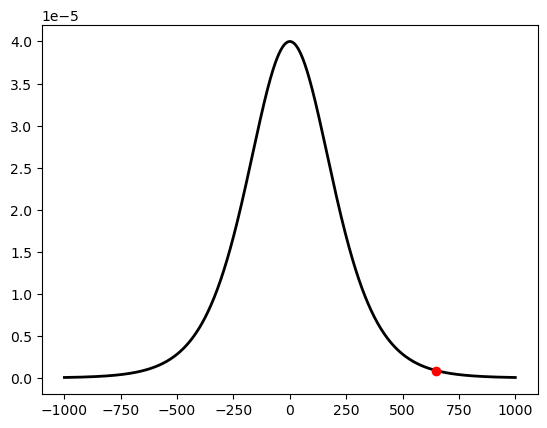

In [15]:
epsilon = np.linspace(-1000,1000,1000)
plt.plot(epsilon, conductance_fun(epsilon), label='Noise Spectrum'
            , color='black', linewidth=2)
plt.plot(pos_on_flanck*eps_w, conductance_fun(pos_on_flanck*eps_w), 'ro', label='Readout Point')

In [16]:
tmax = t_end * T0 # Total time of the simulation
noise_1f = noise.Over_f_noise( n_fluctuators = 8, S1 = kowalski_constant* sigma_noise ,sigma_couplings = 1e-99, ommax = 1/dt_ou, ommin = 1/N_points/tmax,
                    equally_dist = True)
# --- Simulation ---
qubit_states = np.random.choice([-1, 1], size=100)
times = np.arange(0, t_end * T0, dt_ou) # Time points for the simulation


# Simulate the readout signal for each qubit state
Is = []
Qs = []
raw_signal = []
g_noise_list = []
trajectories = [np.array([noise_1f.update(dt_ou) for k in range(len(times))])]

for qn,qubit_state in enumerate(qubit_states):
    trajectories.append(np.array([noise_1f.update(dt_ou) for k in range(len(times))]))  # TODO: vectorise to speed up.
    g_noise, t_sim, raw_signal_now_white, Vout_t, I, Q = get_IQ_signal_ODE(times, qubit_state, params,trajectories[-1])
    Is.append(I)
    Qs.append(Q)
    raw_signal.append(raw_signal_now_white)
    g_noise_list.append(g_noise)  # Store the noise for each qubit state

In [7]:
Is = np.array(Is)
Qs = np.array(Qs)


def integrate_IQ_signal(I,Q):
    I_int = np.cumsum(I, axis=1)/np.arange(1, I.shape[1] + 1)  # Cumulative average
    Q_int = np.cumsum(Q, axis=1)/np.arange(1, Q.shape[1] + 1)  # Cumulative average
    return I_int, Q_int

Iints, Qints = integrate_IQ_signal(Is, Qs) #integrated signal and normalised.




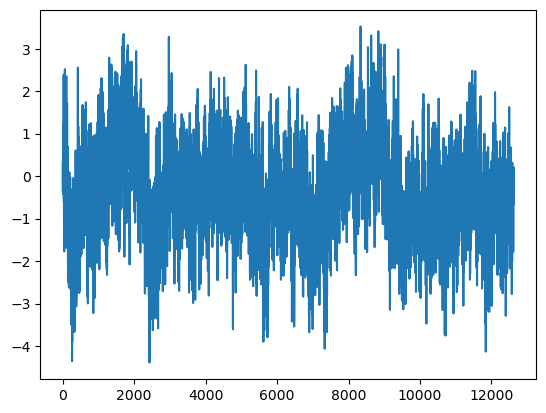

In [8]:
# Combine all arrays in the 'trajectories' list into a single 1D numpy array
all_trajectories = np.concatenate(trajectories)
plt.plot(all_trajectories)

(-7.446962693722331e-06,
 6.876235446225984e-06,
 -0.49996261773436595,
 -0.4999460012879728)

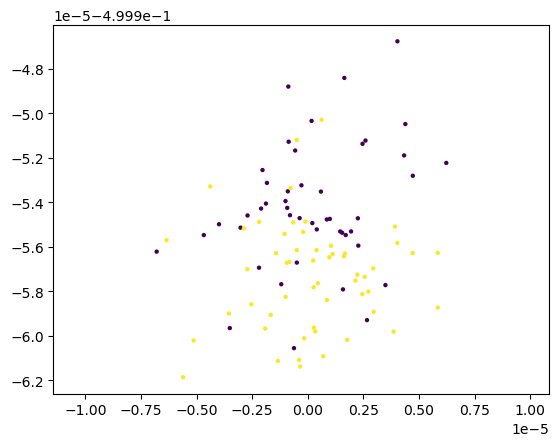

In [9]:
Iints, Qints = integrate_IQ_signal(Is, Qs)

plt.scatter(Iints[:,-1], Qints[:,-1], c=qubit_states, cmap='viridis', s=10, alpha=1, edgecolors='none')
plt.axis("equal")

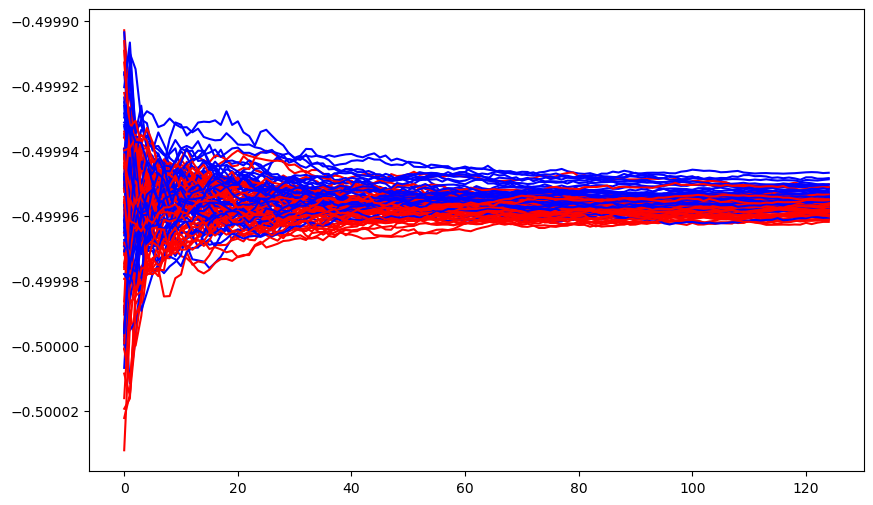

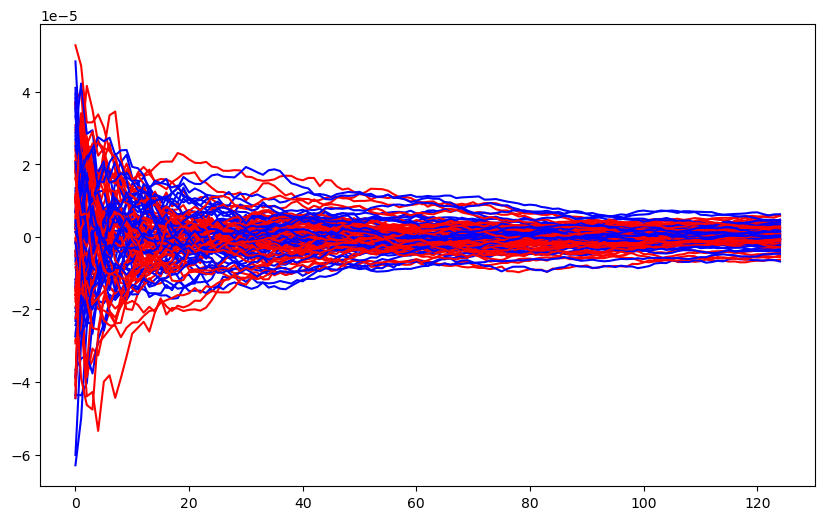

In [10]:
Iints, Qints = integrate_IQ_signal(Is, Qs)
colors = ["","red","blue"]
fig, ax1 = plt.subplots(figsize=(10, 6))
fig, ax2 = plt.subplots(figsize=(10, 6))
for k in range(0, len(qubit_states)):
    ax1.plot(Qints[k] , color=colors[qubit_states[k]], alpha=1)
    ax2.plot(Iints[k],color=colors[qubit_states[k]], alpha=1)
